In [99]:
import pandas as pd
import numpy as np

dfs=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

df=dfs[0]

df=df.replace('Not assigned',np.nan)

df.dropna(subset=['Borough'],inplace=True)

df.fillna('',inplace=True)

df['Neighbourhood']=df.groupby(['Postcode','Borough'])['Neighbourhood'].transform(lambda x: ','.join(x))
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
df['Neighbourhood']=df['Neighbourhood'].replace('',df['Borough'])
df=df.rename(columns={"Postcode":"Postal Code","Neighbourhood":"Neighborhood"})

In [100]:
df.shape

(103, 3)

In [101]:
geo=pd.read_csv('http://cocl.us/Geospatial_data')

In [102]:
data=pd.concat([df.set_index(['Postal Code']),geo.set_index(['Postal Code'])], axis=1, sort=False)
data.head()

,Borough,Neighborhood,Latitude,Longitude
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [103]:
import folium
from geopy.geocoders import Nominatim

address = 'Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [104]:
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [108]:
CLIENT_ID = '4L1Y0Q54KVHTEOXO35RCVHPWRU23TJ1T5DS4USLXLR2BU5LS'
CLIENT_SECRET = 'TETE32F4ZQY3SH4KVWFR3AKUT4SEUF4R4HLZJAELSIQ05JKC'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4L1Y0Q54KVHTEOXO35RCVHPWRU23TJ1T5DS4USLXLR2BU5LS
CLIENT_SECRET:TETE32F4ZQY3SH4KVWFR3AKUT4SEUF4R4HLZJAELSIQ05JKC


In [110]:
data=data.reset_index()
data.loc[0,'Borough']

t_latitude = data.loc[0, 'Latitude'] # neighborhood latitude value
t_longitude = data.loc[0, 'Longitude'] # neighborhood longitude value

t_name = data.loc[0, 'Neighborhood']

In [111]:
import json
import requests

LIMIT = 100
radius = 5000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    t_latitude, 
    t_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=4L1Y0Q54KVHTEOXO35RCVHPWRU23TJ1T5DS4USLXLR2BU5LS&client_secret=TETE32F4ZQY3SH4KVWFR3AKUT4SEUF4R4HLZJAELSIQ05JKC&v=20180605&ll=43.7532586,-79.3296565&radius=5000&limit=100'

In [112]:
results = requests.get(url).json()

In [113]:
from pandas.io.json import json_normalize

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,Donalda Golf & Country Club,Golf Course,43.752816,-79.342741
2,Graydon Hall Manor,Event Space,43.763923,-79.342961
3,LA Fitness,Gym / Fitness Center,43.747665,-79.347077
4,Damas Grillhouse & Juice Bar,Mediterranean Restaurant,43.741839,-79.309296


In [114]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [117]:
t_venues = getNearbyVenues(names=data['Neighborhood'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront,Regent Park
Lawrence Heights,Lawrence Manor
Queen's Park
Islington Avenue
Rouge,Malvern
Don Mills North
Woodbine Gardens,Parkview Hill
Ryerson,Garden District
Glencairn
Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park
Highland Creek,Rouge Hill,Port Union
Flemingdon Park,Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe
Guildwood,Morningside,West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor,Downsview North,Wilson Heights
Thorncliffe Park
Adelaide,King,Richmond
Dovercourt Village,Dufferin
Scarborough Village
Fairview,Henry Farm,Oriole
Northwood Park,York University
East Toronto
Harbourfront East,Toronto Islands,Union Station
Little Portugal,Trinity
East Birchmount Park,Ionview,Kennedy Park
Bayview Village
CFB Toronto,Downsview East
The Danforth West,Riverdale
Design E

In [120]:
t_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",3,3,3,3,3,3
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",8,8,8,8,8,8
"Alderwood,Long Branch",8,8,8,8,8,8
"Bathurst Manor,Downsview North,Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",23,23,23,23,23,23
Berczy Park,57,57,57,57,57,57


In [122]:
t_onehot = pd.get_dummies(t_venues[['Venue Category']], prefix="", prefix_sep="")

t_onehot['Neighborhood'] = t_venues['Neighborhood'] 

fixed_columns = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns]

t_grouped = t_onehot.groupby('Neighborhood').mean().reset_index()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"Alderwood,Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,"Bedford Park,Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"Birch Cliff,Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [125]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [236]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = t_grouped['Neighborhood']

for ind in np.arange(t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Bar,Asian Restaurant,Burger Joint,Hotel,Restaurant
1,Agincourt,Lounge,Skating Rink,Sandwich Place,Breakfast Spot,Chinese Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Coffee Shop,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Fast Food Restaurant,Beer Store,Sandwich Place,Discount Store,Department Store,Dessert Shop
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Gym,Skating Rink,Pharmacy,Pub,Sandwich Place,Women's Store,Diner,Department Store


In [237]:
from sklearn.cluster import KMeans

t_grouped_clustering = t_grouped.drop('Neighborhood', 1)

t_grouped_clustering.dropna(inplace=True)

In [238]:
lista=[]
for i in range(1,20):
    cluster=KMeans(n_clusters=i, random_state=0).fit(t_grouped_clustering)
    lista.append(cluster.inertia_)

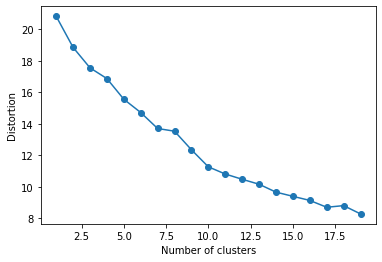

In [239]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20), lista, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [240]:
kclusters=6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(t_grouped_clustering)

In [241]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

t_merged = data

t_merged = t_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

t_merged.dropna(inplace=True)

t_merged.shape

(99, 16)

In [244]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(t_merged['Latitude'], t_merged['Longitude'], t_merged['Neighborhood'], t_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-3],
        fill=True,
        fill_color=rainbow[int(cluster)-3],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters